In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

df= pd.read_csv('bank-additional-full.csv', sep=';', encoding='utf-8')
# Results for all clients
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2]:
#Categorising ages into bins
bins = [0,20,40,60,80,100]
labels = ['1-20','21-40','41-60','61-80','81-100']
df['age_bin']=pd.cut(df['age'], bins=bins, labels=labels)

#Set max values 
df['campaign']=df['campaign'].apply(lambda x: min(4, x))

#Applying one hot encoding to categorical columns
df=pd.get_dummies(df,columns=['age_bin'], dtype=int)
df=pd.get_dummies(df, columns=['job'], dtype=int)
df= pd.get_dummies(df, columns=['marital'], dtype=int)
df= pd.get_dummies(df, columns=['education'], dtype=int)
df= pd.get_dummies(df, columns=['default'], dtype=int)
df= pd.get_dummies(df, columns=['housing'], dtype=int)
df= pd.get_dummies(df, columns=['loan'], dtype=int)
df= pd.get_dummies(df, columns=['contact'], dtype=int)
df= pd.get_dummies(df, columns=['month'], dtype=int)
df= pd.get_dummies(df, columns=['day_of_week'], dtype=int)
# df= pd.get_dummies(df, columns=['campaign'], dtype=int)
df= pd.get_dummies(df, columns=['poutcome'], dtype=int)


#Replacing negative values to zero
# df['emp.var.rate']=df['emp.var.rate'].apply(lambda x: max(0, x))
# df['cons.conf.idx']=df['cons.conf.idx'].apply(lambda x: max(0, x))

#One hot encoding of 'y' column
df['y']=df['y'].replace({'yes':1,'no':0})

#Dropping column
df = df.drop('duration', axis=1)
df = df.drop('age',axis=1)
# f = df.drop('age_bin_61-80',axis=1)
# df = df.drop('age_bin_1-20',axis=1)
# df = df.drop('age_bin_81-100',axis=1)d
df = df.drop('job_unknown',axis=1)
df = df.drop('marital_unknown',axis=1)
df = df.drop('education_unknown',axis=1)
df = df.drop('default_unknown',axis=1)
df = df.drop('housing_unknown',axis=1)
df = df.drop('loan_unknown',axis=1)
# df=df.drop('emp.var.rate',axis=1)
# df=df.drop('cons.price.idx',axis=1)
# df=df.drop('cons.conf.idx',axis=1)
# df=df.drop('euribor3m',axis=1)
# df=df.drop('nr.employed',axis=1)

#Replacing values
df['pdays']=df['pdays'].replace({999:0})

#Rearranging columns
cols = list(df.columns)
cols.remove('y')           
cols.insert(cols.index('poutcome_success') + 1, 'y')  

# Reorder dataframe
df = df[cols]

/var/folders/3t/kqzykkfx49d7ljggm3b2fc3m0000gn/T/ipykernel_3485/2255383330.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y']=df['y'].replace({'yes':1,'no':0})


In [3]:
df.tail(14)

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age_bin_1-20,age_bin_21-40,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y
41174,1,1,6,-1.1,94.767,-50.8,1.031,4963.6,0,0,...,0,0,0,1,0,0,0,0,1,1
41175,1,0,2,-1.1,94.767,-50.8,1.031,4963.6,0,1,...,0,0,0,1,0,0,1,0,0,0
41176,1,0,0,-1.1,94.767,-50.8,1.031,4963.6,0,1,...,0,0,0,1,0,0,0,1,0,0
41177,4,0,0,-1.1,94.767,-50.8,1.031,4963.6,0,0,...,0,0,0,1,0,0,0,1,0,0
41178,2,6,3,-1.1,94.767,-50.8,1.031,4963.6,0,0,...,0,0,0,1,0,0,0,0,1,1
41179,3,0,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,...,0,1,0,0,0,0,0,1,0,0
41180,2,0,0,-1.1,94.767,-50.8,1.028,4963.6,0,1,...,0,1,0,0,0,0,0,1,0,0
41181,1,0,0,-1.1,94.767,-50.8,1.028,4963.6,0,1,...,0,1,0,0,0,0,0,1,0,1
41182,1,9,1,-1.1,94.767,-50.8,1.028,4963.6,0,1,...,0,1,0,0,0,0,0,0,1,0
41183,1,0,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,...,0,1,0,0,0,0,0,1,0,1


In [4]:
# Define x and y
# x=df.iloc[:,0:57]
# y=df.iloc[:,-1]

# Select top 3 features
# best_features=SelectKBest(score_func=chi2,k=3)
# fit=best_features.fit(x,y)

# Create data frames for the features and the score of each feature
# df_scores=pd.DataFrame(fit.scores_)
# df_columns=pd.DataFrame(x.columns)

# Combine all the features and their correspionding scores in one data frame
# features_scores=pd.concat([df_columns,df_scores], axis=1)
# features_scores.columns=['Features','Score']
# features_scores.sort_values(by='Score').tail(50)

In [5]:
x= df.drop(['y'], axis=1)  # Features
y= df['y']

#Oversampling
sm = SMOTE()
x,y = sm.fit_resample(x,y)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

#Standardise data
sc=StandardScaler()
categories=['campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
x_train[categories]=sc.fit_transform(x_train[categories])
x_test[categories]=sc.transform(x_test[categories])

Logistic Regression Model

In [6]:
logregmodel=LogisticRegression()
logregmodel.fit(x_train,y_train)

y_pred_logreg=logregmodel.predict(x_test)
print(x_test)
print(y_pred_logreg)

       campaign     pdays  previous  emp.var.rate  cons.price.idx  \
46673 -0.823942 -0.300110 -0.442846     -0.759541       -0.927697   
10186  1.032988 -0.300110 -0.442846      1.099323        1.558368   
71199 -0.823942 -0.300110 -0.442846     -1.398525       -0.816995   
48227 -0.823942  2.475792  2.799611     -0.759541       -0.174919   
47094 -0.823942  2.475792  1.178382     -0.701451        0.865686   
...         ...       ...       ...           ...             ...   
12934  0.104523 -0.300110 -0.442846      1.099323        0.693306   
29567 -0.823942 -0.300110  1.178382     -0.759541       -0.639870   
13001  1.961452 -0.300110 -0.442846      1.099323        0.693306   
66787 -0.823942 -0.300110 -0.442846     -0.759541       -0.927697   
8236  -0.823942 -0.300110 -0.442846      1.099323        1.558368   

       cons.conf.idx  euribor3m  nr.employed  age_bin_1-20  age_bin_21-40  \
46673      -1.121458  -0.885836    -0.419449             0              1   
10186      -0.298

/Users/c-files/Desktop/DI_Bootcamp/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
print('Logistic Regression:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_logreg))
print('Recall: ',metrics.recall_score(y_test, y_pred_logreg, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_logreg, zero_division=1))
print('CL Report: \n',metrics.classification_report(y_test, y_pred_logreg, zero_division=1))
accuracy_log=metrics.accuracy_score(y_test, y_pred_logreg)

Logistic Regression:
Accuracy:  0.9042407660738714
Recall:  0.8626509330406147
Precision:  0.9403230631169608
CL Report: 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      7332
           1       0.94      0.86      0.90      7288

    accuracy                           0.90     14620
   macro avg       0.91      0.90      0.90     14620
weighted avg       0.91      0.90      0.90     14620



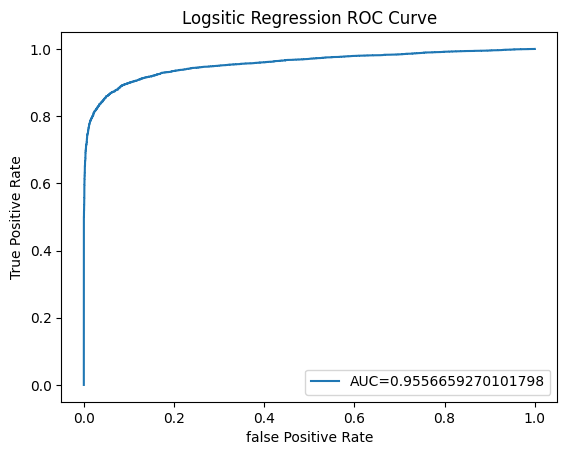

In [8]:
y_pred_proba= logregmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Logsitic Regression ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

Random Forest Classifier Model

In [9]:
rfcmodel = RandomForestClassifier()
rfcmodel.fit(x_train, y_train)

y_pred_rfc=rfcmodel.predict(x_test)
print(x_test)
print(y_pred_rfc)

       campaign     pdays  previous  emp.var.rate  cons.price.idx  \
46673 -0.823942 -0.300110 -0.442846     -0.759541       -0.927697   
10186  1.032988 -0.300110 -0.442846      1.099323        1.558368   
71199 -0.823942 -0.300110 -0.442846     -1.398525       -0.816995   
48227 -0.823942  2.475792  2.799611     -0.759541       -0.174919   
47094 -0.823942  2.475792  1.178382     -0.701451        0.865686   
...         ...       ...       ...           ...             ...   
12934  0.104523 -0.300110 -0.442846      1.099323        0.693306   
29567 -0.823942 -0.300110  1.178382     -0.759541       -0.639870   
13001  1.961452 -0.300110 -0.442846      1.099323        0.693306   
66787 -0.823942 -0.300110 -0.442846     -0.759541       -0.927697   
8236  -0.823942 -0.300110 -0.442846      1.099323        1.558368   

       cons.conf.idx  euribor3m  nr.employed  age_bin_1-20  age_bin_21-40  \
46673      -1.121458  -0.885836    -0.419449             0              1   
10186      -0.298

In [10]:
print('Random Forest Classifier:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_rfc))
print('Recall: ',metrics.recall_score(y_test, y_pred_rfc, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_rfc, zero_division=1))
print('CL Report: \n',metrics.classification_report(y_test, y_pred_rfc, zero_division=1))
accuracy_rfc=metrics.accuracy_score(y_test, y_pred_rfc)

Random Forest Classifier:
Accuracy:  0.9328317373461013
Recall:  0.9356476399560922
Precision:  0.9300327332242226
CL Report: 
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      7332
           1       0.93      0.94      0.93      7288

    accuracy                           0.93     14620
   macro avg       0.93      0.93      0.93     14620
weighted avg       0.93      0.93      0.93     14620



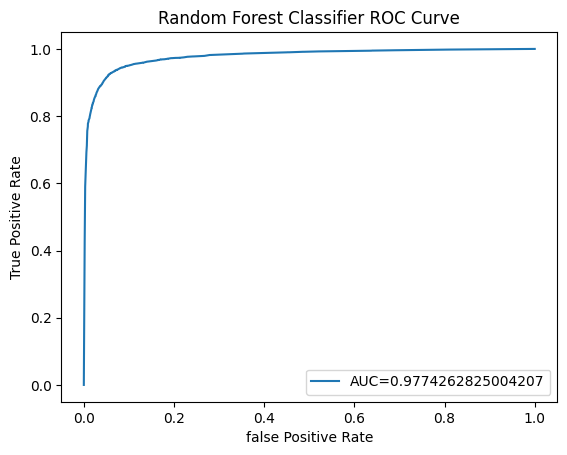

In [11]:
y_pred_proba= rfcmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Random Forest Classifier ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

Decision Tree Classifier Model

In [12]:
dtcmodel = DecisionTreeClassifier()
dtcmodel.fit(x_train, y_train)

y_pred_dtc=dtcmodel.predict(x_test)
print(x_test)
print(y_pred_dtc)

       campaign     pdays  previous  emp.var.rate  cons.price.idx  \
46673 -0.823942 -0.300110 -0.442846     -0.759541       -0.927697   
10186  1.032988 -0.300110 -0.442846      1.099323        1.558368   
71199 -0.823942 -0.300110 -0.442846     -1.398525       -0.816995   
48227 -0.823942  2.475792  2.799611     -0.759541       -0.174919   
47094 -0.823942  2.475792  1.178382     -0.701451        0.865686   
...         ...       ...       ...           ...             ...   
12934  0.104523 -0.300110 -0.442846      1.099323        0.693306   
29567 -0.823942 -0.300110  1.178382     -0.759541       -0.639870   
13001  1.961452 -0.300110 -0.442846      1.099323        0.693306   
66787 -0.823942 -0.300110 -0.442846     -0.759541       -0.927697   
8236  -0.823942 -0.300110 -0.442846      1.099323        1.558368   

       cons.conf.idx  euribor3m  nr.employed  age_bin_1-20  age_bin_21-40  \
46673      -1.121458  -0.885836    -0.419449             0              1   
10186      -0.298

In [13]:
print('Decision Tree Classifier:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_dtc))
print('Recall: ',metrics.recall_score(y_test, y_pred_dtc, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_dtc, zero_division=1))
print('CL Report: \n',metrics.classification_report(y_test, y_pred_dtc, zero_division=1))
accuracy_dtc=metrics.accuracy_score(y_test, y_pred_dtc)

Decision Tree Classifier:
Accuracy:  0.9038303693570452
Recall:  0.9153402854006586
Precision:  0.8942359249329759
CL Report: 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      7332
           1       0.89      0.92      0.90      7288

    accuracy                           0.90     14620
   macro avg       0.90      0.90      0.90     14620
weighted avg       0.90      0.90      0.90     14620



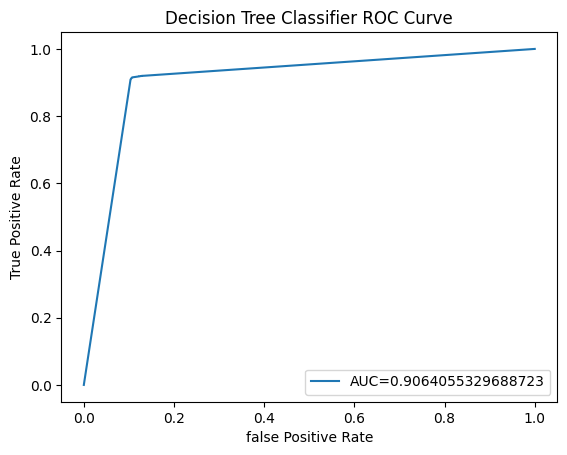

In [14]:
y_pred_proba= dtcmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Decision Tree Classifier ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

Naive Bayes Model

In [15]:
nbmodel = GaussianNB()
nbmodel.fit(x_train, y_train)

y_pred_nb=nbmodel.predict(x_test)
print(x_test)
print(y_pred_nb)

       campaign     pdays  previous  emp.var.rate  cons.price.idx  \
46673 -0.823942 -0.300110 -0.442846     -0.759541       -0.927697   
10186  1.032988 -0.300110 -0.442846      1.099323        1.558368   
71199 -0.823942 -0.300110 -0.442846     -1.398525       -0.816995   
48227 -0.823942  2.475792  2.799611     -0.759541       -0.174919   
47094 -0.823942  2.475792  1.178382     -0.701451        0.865686   
...         ...       ...       ...           ...             ...   
12934  0.104523 -0.300110 -0.442846      1.099323        0.693306   
29567 -0.823942 -0.300110  1.178382     -0.759541       -0.639870   
13001  1.961452 -0.300110 -0.442846      1.099323        0.693306   
66787 -0.823942 -0.300110 -0.442846     -0.759541       -0.927697   
8236  -0.823942 -0.300110 -0.442846      1.099323        1.558368   

       cons.conf.idx  euribor3m  nr.employed  age_bin_1-20  age_bin_21-40  \
46673      -1.121458  -0.885836    -0.419449             0              1   
10186      -0.298

In [16]:
print('Naive Bayes:')
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_nb))
print('Recall: ',metrics.recall_score(y_test, y_pred_nb, zero_division=1))
print('Precision: ',metrics.precision_score(y_test, y_pred_nb, zero_division=1))
print('CL Report: \n',metrics.classification_report(y_test, y_pred_nb, zero_division=1))
accuracy_nb=metrics.accuracy_score(y_test, y_pred_nb)

Naive Bayes:
Accuracy:  0.7445280437756497
Recall:  0.743688254665203
Precision:  0.7437903115136545
CL Report: 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75      7332
           1       0.74      0.74      0.74      7288

    accuracy                           0.74     14620
   macro avg       0.74      0.74      0.74     14620
weighted avg       0.74      0.74      0.74     14620



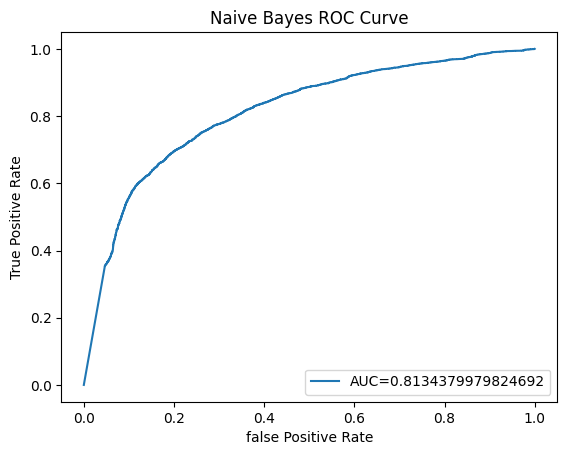

In [17]:
y_pred_proba= nbmodel.predict_proba(x_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('Naive Bayes ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

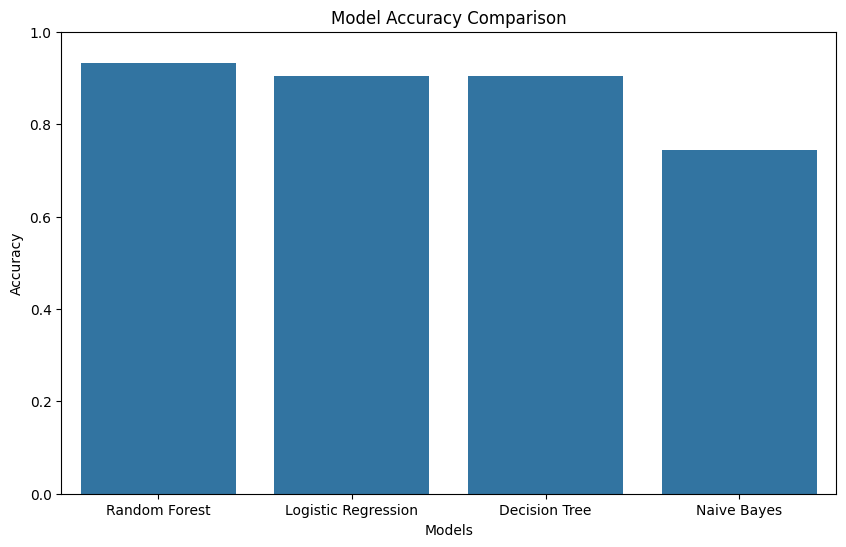

In [18]:
#visualise the results
plt.figure(figsize=(10, 6))
sns.barplot(x=['Random Forest','Logistic Regression','Decision Tree','Naive Bayes'], 
            y=[accuracy_rfc,accuracy_log,accuracy_dtc,accuracy_nb])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 1)  # Set y-axis limit to 0-
plt.show()

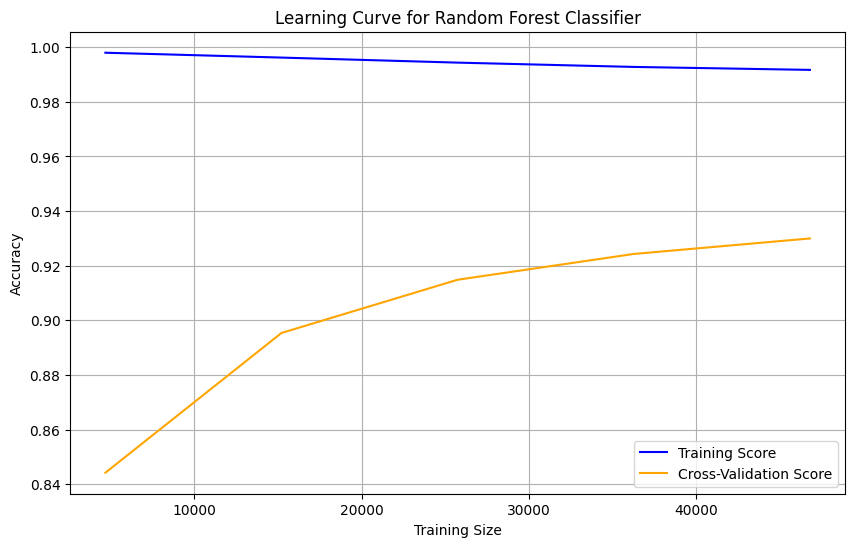

In [19]:
#learning curve for Random Forest
train_sizes, train_scores, test_scores = learning_curve(rfcmodel, x_train, y_train
, cv=5, scoring='accuracy', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange')

plt.title('Learning Curve for Random Forest Classifier')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [20]:
#Validating model
#Standardise the data 
df_pred=df.copy()
df_pred[categories]=sc.transform(df_pred[categories])

In [53]:
#Selecting a row with 'y'=='yes'
row = df_pred.iloc[41174]
row

# As tuple
record = tuple(row)
record=tuple(record[:-1])
print(record)

prediction = rfcmodel.predict([record])
prediction

(-0.8239417687716605, 0.16254000742438016, 9.284526851145428, -0.35291445922288733, 2.0359709582411676, -1.9814207452533859, -1.0233927024393672, -1.9773745579798911, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0)


/Users/c-files/Desktop/DI_Bootcamp/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])

In [64]:
print(df.columns.tolist())

['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'age_bin_1-20', 'age_bin_21-40', 'age_bin_41-60', 'age_bin_61-80', 'age_bin_81-100', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcom

In [ ]:
prediction = rfcmodel.predict([(-0.8239417687716605, 0.16254000742438016, 9.284526851145428, -0.35291445922288733, 2.0359709582411676, -1.9814207452533859, -1.0233927024393672, -1.9773745579798911, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0, 0,1.0, 0)])
prediction

/Users/c-files/Desktop/DI_Bootcamp/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])